In [47]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import catboost as cb
from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor, DMatrix

import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report

import warnings
warnings.filterwarnings('ignore')

In [21]:
train = pd.read_csv('data/quickstart_train.csv')
test = pd.read_csv('data/quickstart_test.csv')

RANDOM_STATE = 8800

# Вспомогательные функции

In [19]:
def plot_numerical_feature_histogram(df1, df2, feature_title, label=None, text_info=True, bins=50,
                                     figure_width=17, figure_height=7, fontsize=15, number_of_decimals=2, title=''):
    NCOLS_NUMBER_CONST = 1

    if label is None:
        label = feature_title

    fig, ax = plt.subplots(ncols=1, figsize=(figure_width, figure_height))

    sns.histplot(data=df1, x=feature_title, color="cornflowerblue", label=label, bins=bins, kde=True)
    mean_value = df1[feature_title].mean()
    median_value = df1[feature_title].median()
    ax.axvline(x=mean_value, color='black', lw=2, ls=':',
               label=f"mean: {round(mean_value, number_of_decimals)}")
    ax.axvline(x=median_value, color='orange', lw=2, ls='-.',
               label=f"median: {round(median_value, number_of_decimals)}")
    ax.legend(fontsize='15', title_fontsize="10", loc='upper right')
    plt.tight_layout()

    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    Q1 = df1[feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = df1[feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1

    sns.histplot(data=df2, x=feature_title, color="orange", label=label, bins=bins, kde=True)
    mean_value = df2[feature_title].mean()
    median_value = df2[feature_title].median()
    ax.axvline(x=mean_value, color='green', lw=2, ls=':',
               label=f"mean: {round(mean_value, number_of_decimals)}")
    ax.axvline(x=median_value, color='red', lw=2, ls='-.',
               label=f"median: {round(median_value, number_of_decimals)}")
    ax.legend(fontsize='15', title_fontsize="10", loc='upper right')
    plt.tight_layout()

    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    Q1 = df2[feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = df2[feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1

    plt.show()

def plot_dataframes_features_info(df1, df2, name):
    print('\n', name, '\n')
    for column in df1.describe().columns:
        plot_numerical_feature_histogram(df1, df2, column, figure_width=10, figure_height=5)

# EDA

In [22]:
train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [23]:
cat_features = ["car_type", "fuel_type", "model"]
drop_cols = ["car_id", "target_reg", "target_class"]

X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]

for col in cat_features:
    X[col] = X[col].astype('category')


 train VS test 



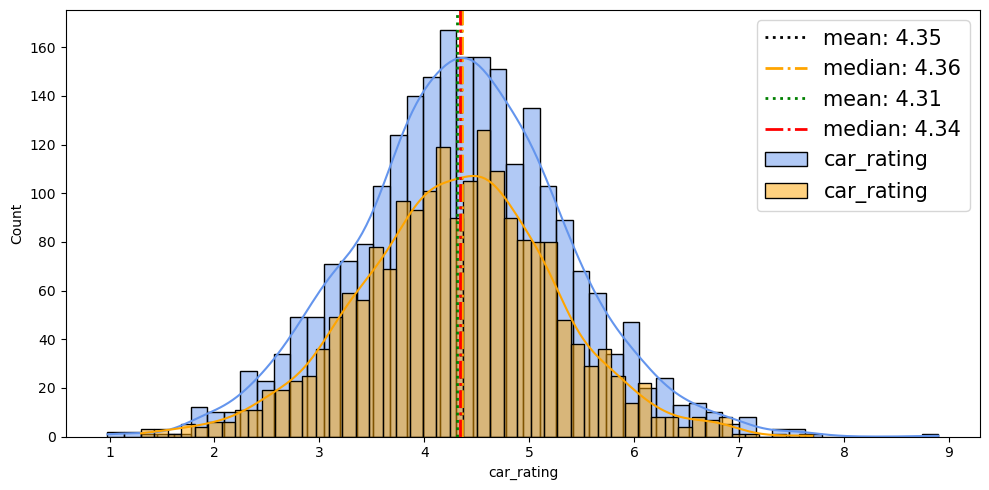

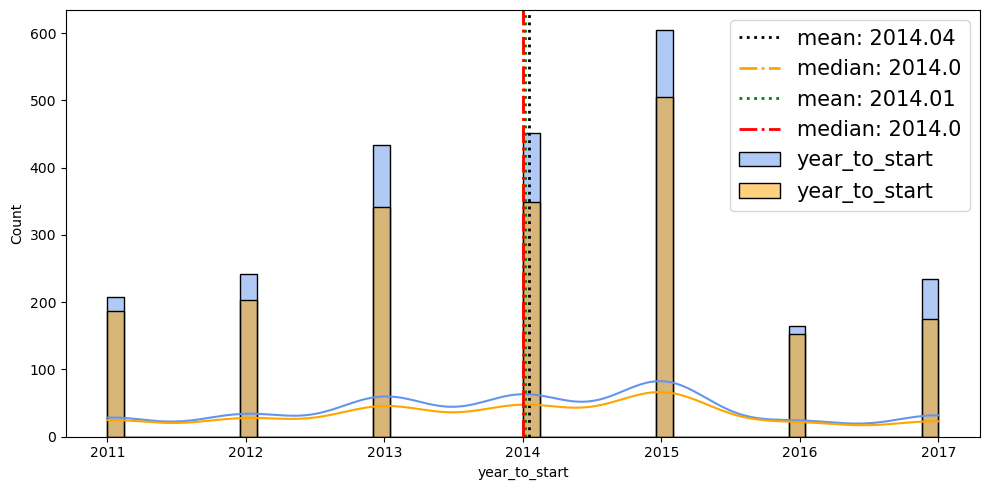

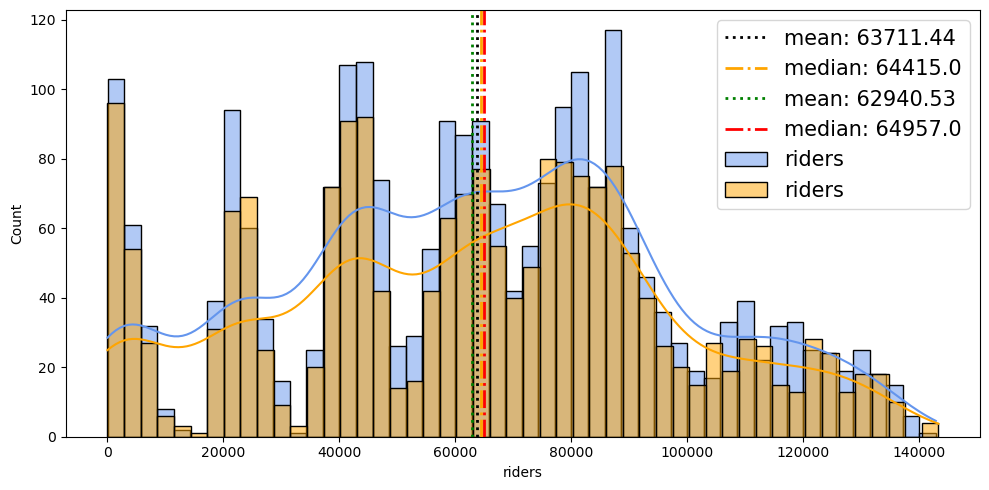

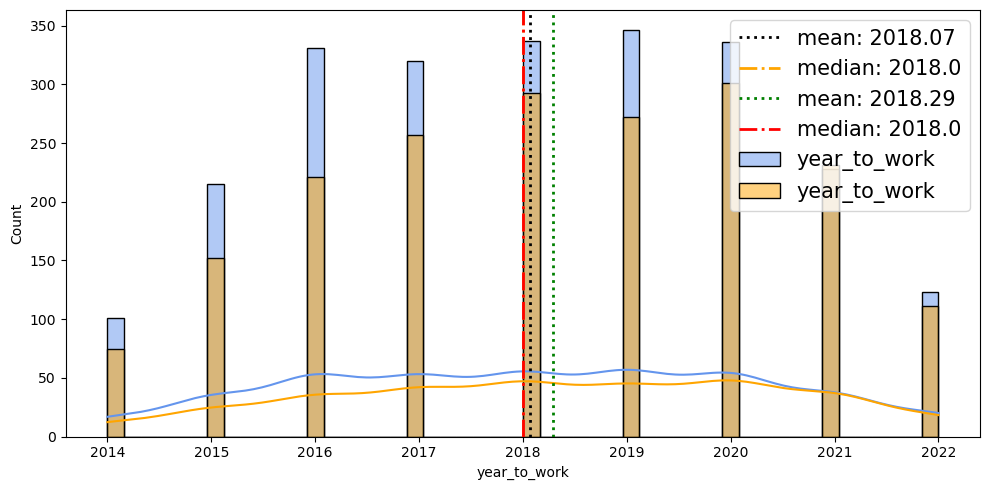

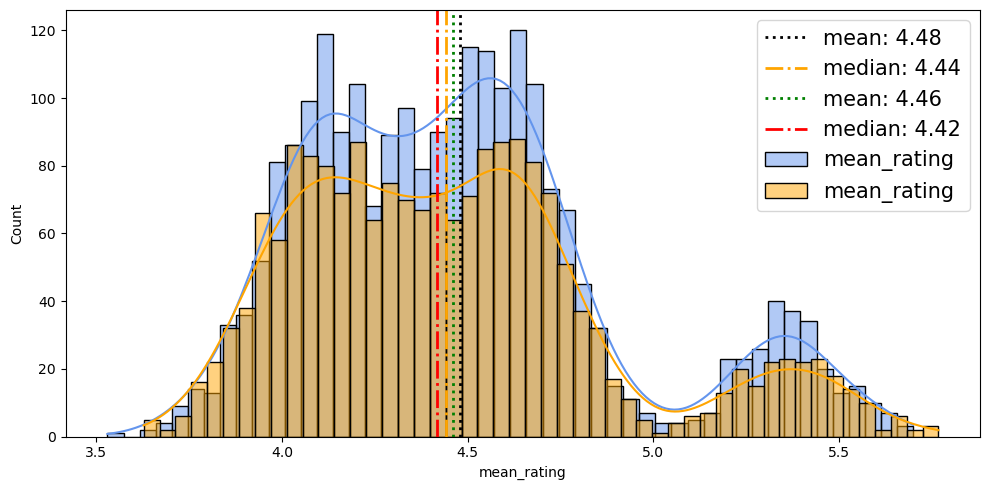

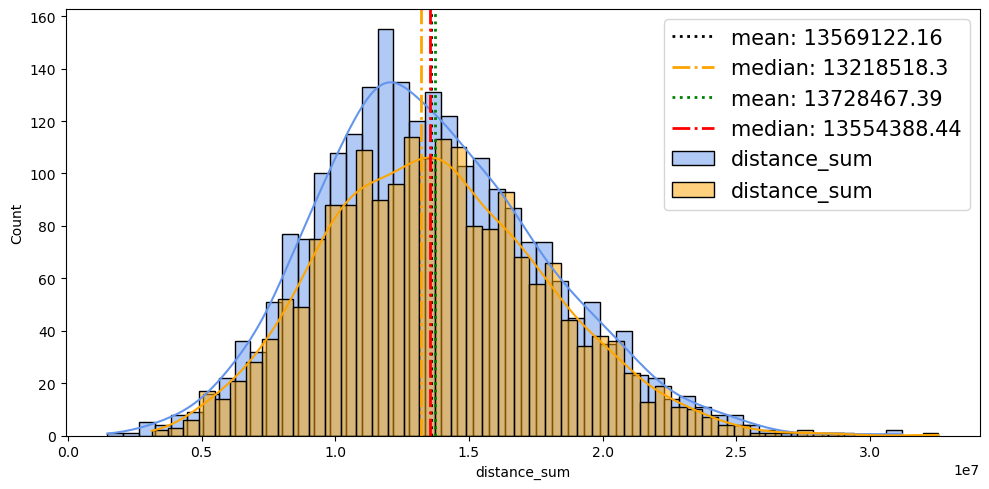

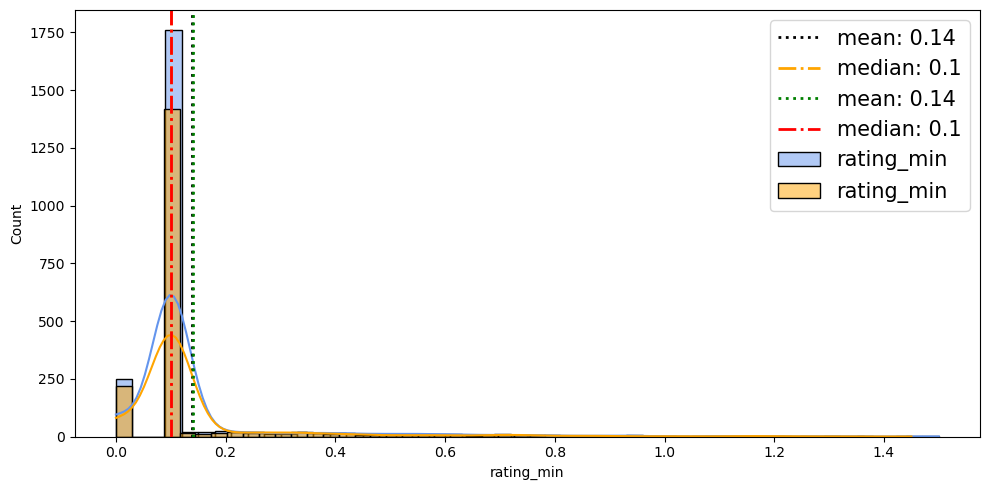

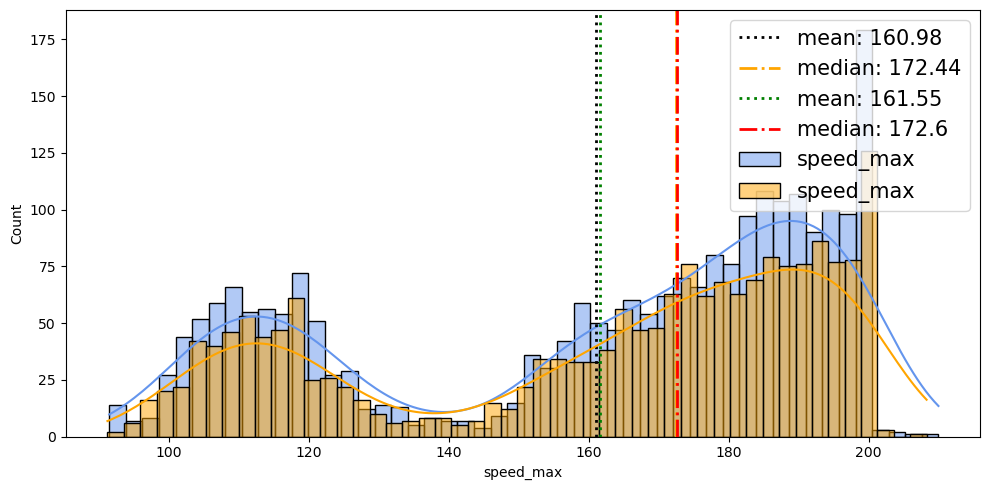

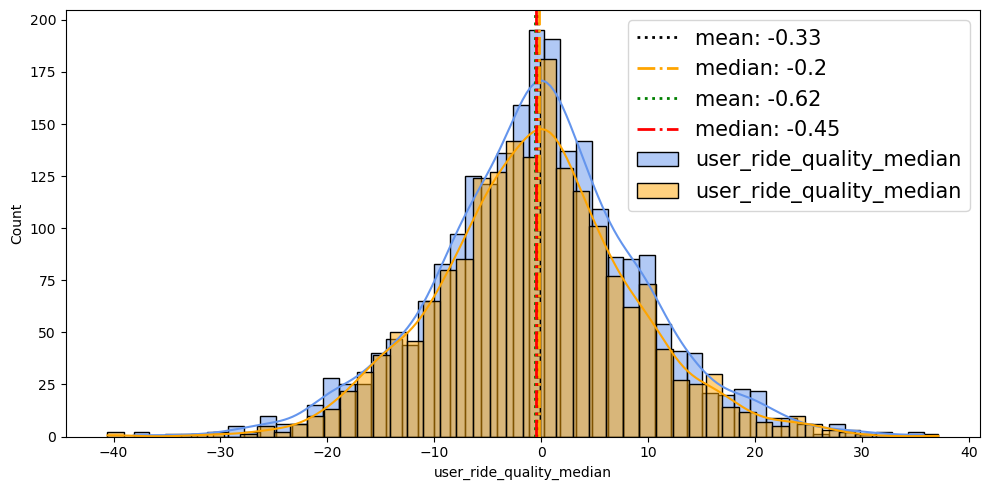

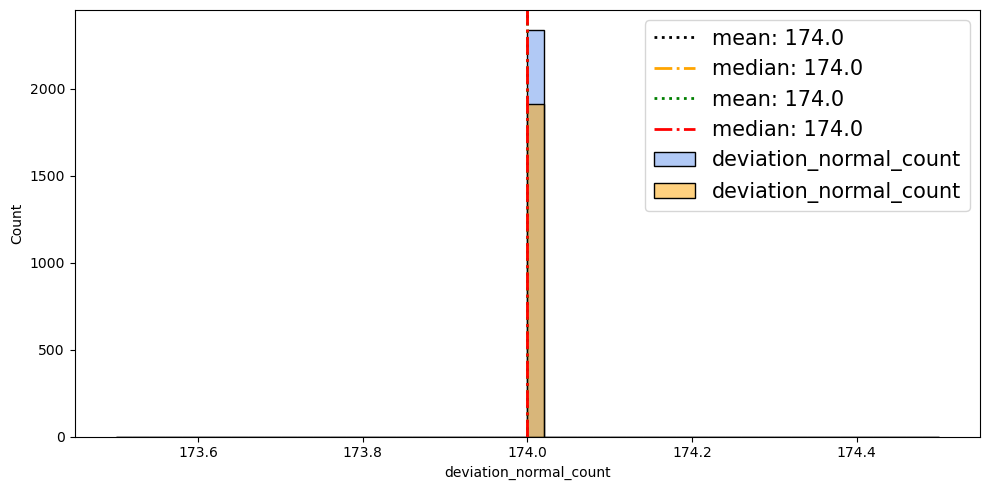

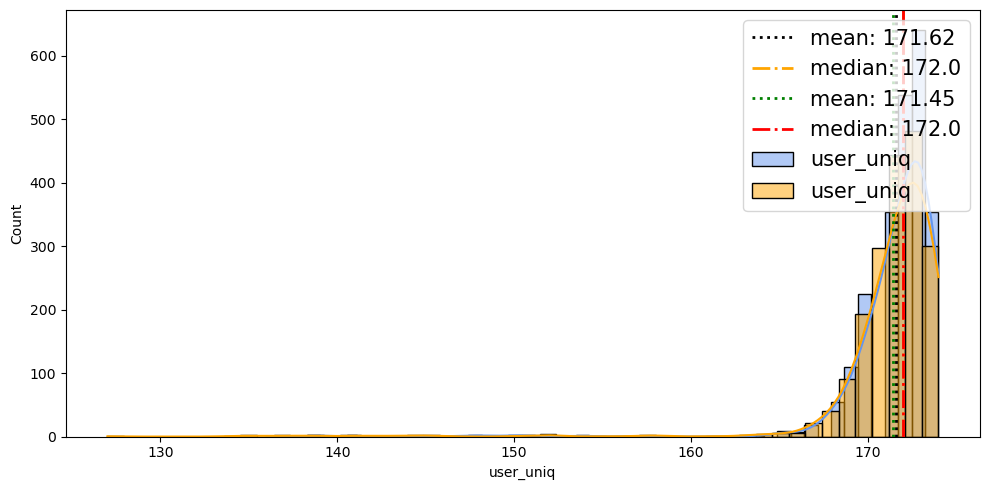

In [24]:
plot_dataframes_features_info(X, test, 'train VS test')

Выборки в целом очень похожи: распределения признаков практически совпадают.
Колонка deviation_normal_count принимает константное значение -> можно отбросить этот признак

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']


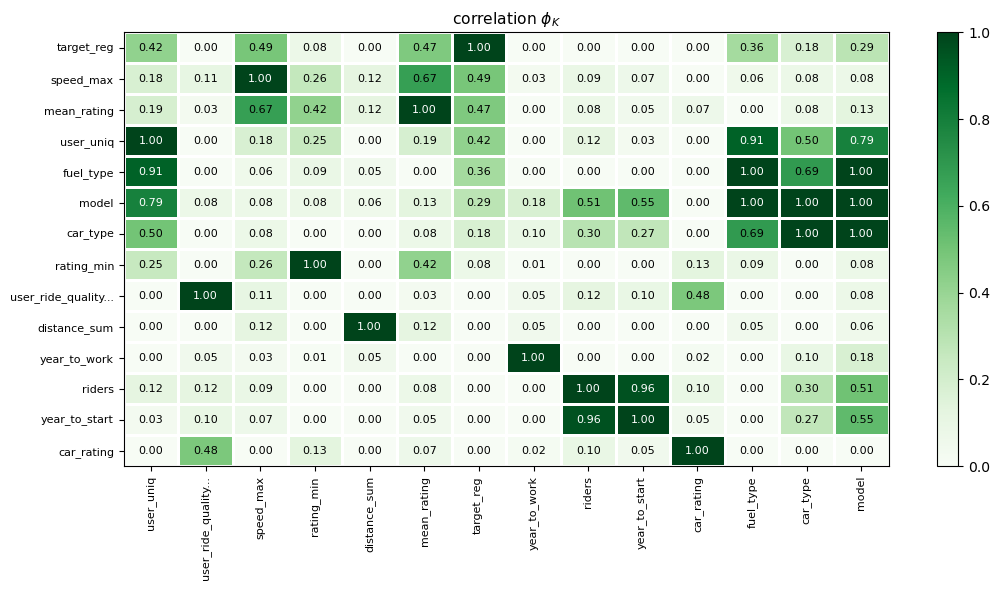

In [27]:
phik_overview = train.drop(['car_id', 'target_class'], axis=1).phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

Признаки с плохой коррелляцией -> ['user_ride_quality_median', 'distance_sum', 'year_to_work', 'rides', 'year_to_start', 'car_rating']. Некоторые эти признаки в дальнейшем можно отбросить.

# Обучение

## Catboost

In [30]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'depth': [4, 6, 8],  # глубина дерева
    'max_ctr_complexity': [1, 3, 5],  # сложность признаков
    'min_data_in_leaf': [1, 3, 5],  # минимальное число объектов в листе
    'random_state': [RANDOM_STATE] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []
best_params = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(loss_function='RMSE', verbose=False)

    # подбор гиперпараметров с использованием случайного поиска - встроенного метода CatBoost
    search_results = model.randomized_search(params, X=train_pool, n_iter=10)

    model.fit(train_pool)
    models.append(model)

    pred = model.predict(val_pool)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse)

    best_params.append(search_results['params'])

    print("Лучшие гиперпараметры для этого сплита:")
    print(search_results['params'])

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(best_params[best_model_index])

best_model.save_model('models/best_model_catboost.cbm')

print('Лучшая модель сохранена. RMSE лучшей модели:', rmse_scores[best_model_index])


bestTest = 11.56566407
bestIteration = 664

0:	loss: 11.5656641	best: 11.5656641 (0)	total: 42.8s	remaining: 6m 25s

bestTest = 11.50842893
bestIteration = 733

1:	loss: 11.5084289	best: 11.5084289 (1)	total: 1m 22s	remaining: 5m 28s

bestTest = 12.08506921
bestIteration = 488

2:	loss: 12.0850692	best: 11.5084289 (1)	total: 2m 40s	remaining: 6m 15s

bestTest = 11.90990551
bestIteration = 445

3:	loss: 11.9099055	best: 11.5084289 (1)	total: 4m	remaining: 6m

bestTest = 11.90990551
bestIteration = 445

4:	loss: 11.9099055	best: 11.5084289 (1)	total: 5m 18s	remaining: 5m 18s

bestTest = 11.50842893
bestIteration = 733

5:	loss: 11.5084289	best: 11.5084289 (1)	total: 5m 55s	remaining: 3m 56s

bestTest = 11.50842893
bestIteration = 733

6:	loss: 11.5084289	best: 11.5084289 (1)	total: 6m 34s	remaining: 2m 49s

bestTest = 11.74564169
bestIteration = 482

7:	loss: 11.7456417	best: 11.5084289 (1)	total: 7m 32s	remaining: 1m 53s

bestTest = 12.08506921
bestIteration = 488

8:	loss: 12.0850692	

### Feature importance

In [33]:
feature_importances = best_model.get_feature_importance(data=train_pool, type=cb.EFstrType.PredictionValuesChange)

feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

feature_importances_df

,Feature,Importance
10,speed_max,37.726612
7,mean_rating,27.482984
9,rating_min,8.370347
8,distance_sum,4.945313
5,riders,4.602584
11,user_ride_quality_median,3.288105
1,car_type,3.196534
3,car_rating,2.761534
13,user_uniq,2.498897
2,fuel_type,2.021092


Последние 3 фичи обладают плохой коррелляцией и имеют плохой importance -> отбросим их и обучим кэтбуст с наилучшими параметрами

### Обучение после feature selection

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

params = {
    'depth': 4,  # глубина дерева
    'max_ctr_complexity': 1,  # сложность признаков
    'min_data_in_leaf': 1,  # минимальное число объектов в листе
    'random_state': RANDOM_STATE # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []
best_params = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(**params, loss_function='RMSE', verbose=False, thread_count=-1)

    model.fit(train_pool)
    models.append(model)

    pred = model.predict(val_pool)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmse_scores.append(rmse)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

best_model.save_model('models/best_model_catboost_after_fs.cbm')

print('Лучшая модель сохранена. RMSE лучшей модели:', rmse_scores[best_model_index])

Лучшая модель сохранена. RMSE лучшей модели: 11.38862512023749


RMSE упал с 11.42 -> 11.38, но самое главное что модель стала быстрее обучаться и устойчива к переобучению.

## LightGBM

In [41]:
cat_features = ['model', 'car_type', 'fuel_type']

train_encoded = train.copy()
test_encoded = test.copy()

# инициализируем LabelEncoder для каждого категориального признака
label_encoders = {}
for feature in cat_features:
    label_encoders[feature] = LabelEncoder()

# кодирование категориальных признаков для тренировочного набора данных
for feature in cat_features:
    train_encoded[feature] = label_encoders[feature].fit_transform(train[feature])

# кодирование категориальных признаков для тестового набора данных
for feature in cat_features:
    test_encoded[feature] = label_encoders[feature].transform(test[feature])

X = train_encoded.drop(['target_reg', 'target_class', 'car_id'], axis=1)
y = train_encoded['target_reg']

In [42]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

params = {
    'boosting_type': ['dart'], # тип алгоритма бустинга
    'objective': ['regression'], # целевая функция для оптимизации
    'metric': ['rmse'], # метрика оценки качества модели
    'num_leaves': [10, 20, 30], # количество листьев в дереве
    'learning_rate': [0.05, 0.1, 0.2], # скорость обучения модели
    'colsample_bytree': [0.8, 0.9], # доля признаков, используемых для построения каждого дерева
    'random_state': [RANDOM_STATE] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)

    # поиск лучших гиперпараметров с использованием случайного поиска sklearn
    model = lgb.LGBMRegressor()
    random_search = RandomizedSearchCV(model, params, n_iter=10, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    callbacks = [
        lgb.early_stopping(10),
        lgb.log_evaluation(period=10)
    ]
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        callbacks=callbacks
    )

    models.append(model)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print("Лучшие гиперпараметры для этого сплита:")
    print(best_params)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(random_search.best_params_)

best_model.save_model('models/best_model_lightgbm.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 1246, number of used features: 13
[LightGBM] [Info] Start training from score 45.214759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1246, number of used features: 13
[LightGBM] [Info] Start training from score 44.716461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set

Модель быстро обучилась с RMSE 11.83 с параметрамами {'random_state': 8800, 'objective': 'regression', 'num_leaves': 20, 'metric': 'rmse', 'learning_rate': 0.2, 'colsample_bytree': 0.8, 'boosting_type': 'dart'}

Feature importance и feature selection

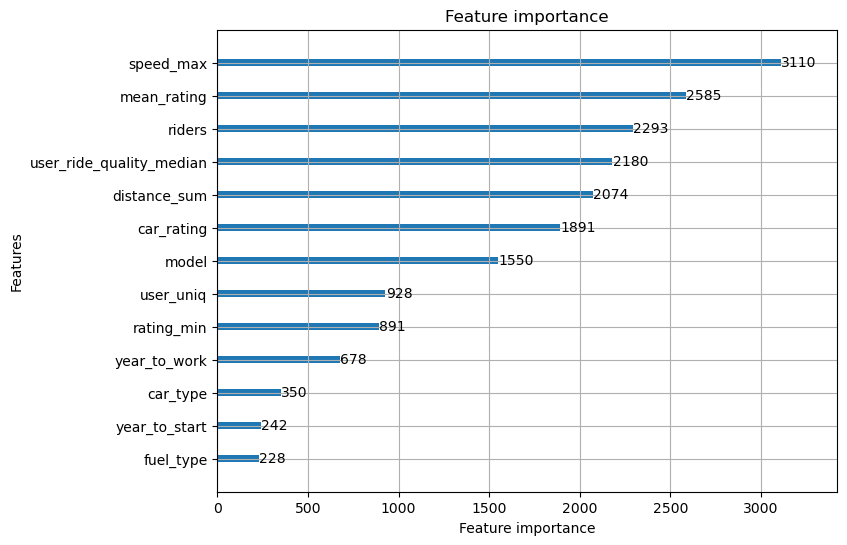

In [43]:
lgb.plot_importance(best_model, figsize=(8, 6));

Отбросим ['year_to_start', 'year_to_work']

In [45]:
X.drop(['year_to_start', 'year_to_work'], axis=1, inplace=True)

In [46]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.LGBMRegressor()
    
    callbacks = [
        lgb.early_stopping(10),
        lgb.log_evaluation(period=10)
    ]
    model = lgb.train(
        best_model.params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        callbacks=callbacks
    )

    models.append(model)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)


best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

best_model.save_model('models/best_model_lightgbm_after_fs.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 1558, number of used features: 11
[LightGBM] [Info] Start training from score 44.997445
[10]	valid_0's rmse: 13.1364
[20]	valid_0's rmse: 11.7657
[30]	valid_0's rmse: 11.8608
[40]	valid_0's rmse: 11.5115
[50]	valid_0's rmse: 11.5739
[60]	valid_0's rmse: 11.8985
[70]	valid_0's rmse: 11.7538
[80]	valid_0's rmse: 11.6844
[90]	valid_0's rmse: 12.106
[100]	valid_0's rmse: 11.9363
[110]	valid_0's rmse: 11.8535
[120]	valid_0's rmse: 11.9686
[130]	valid_0's rmse: 11.8322
[140]	valid_0's rmse: 11.7401
[150]	valid_0's rmse: 11.734
[160]	valid_0's rmse: 11.6076
[170]	valid_0's rmse: 11.5893
[180]	valid_0's rmse: 11.6378
[190]	valid_0's rmse: 11.7302
[200]	valid_0's rmse: 11.6982
[210]	valid_0's rmse: 11.7232
[220]	valid_0's rmse: 11.7473
[230]	val

RMSE модели почти не изменился. Однако обучение модели произошло быстрее.

## XGBoost

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

params = {
    'objective': ['reg:squarederror'], # целевая функция для оптимизации
    'eval_metric': ['rmse'], # метрика оценки качества модели
    'eta': [0.01, 0.1, 0.2], # скорость обучения модели
    'booster': ['dart'], # метод бустинга
    'rate_drop': [0.1], # вероятность отключения (dropout) каждого дерева в процессе обучения
    'skip_drop': [0.5], # вероятность пропуска dropout для каждого дерева при обучении
    'max_depth': [3, 6, 9], # максимальная глубина дерева
    'subsample': [0.8, 0.9, 1.0], # доля экземпляров из обучающей выборки, используемая для построения дерева
    'colsample_bytree': [0.8, 0.9, 1.0], # доля признаков, используемых для построения дерева
    'colsample_bylevel': [0.8, 0.9, 1.0], # доля признаков на уровне дерева
    'colsample_bynode': [0.8, 0.9, 1.0], # доля признаков в каждом разбиении узла дерева
    'lambda': [0.1, 1, 10], # коэффициент L2-регуляризации
    'alpha': [0, 0.1, 1], # коэффициент L1-регуляризации
    'gamma': [0, 0.1, 1], # минимальное изменение потери для разделения ветви дерева
    'min_child_weight': [1, 5, 10], # минимальная сумма весов экземпляров в листовом узле
    'max_bin': [256, 512, 1024], # максимальное число бинов для разбиения числового признака
    'seed': [RANDOM_STATE] # зерно генерации случайных чисел для воспроизводимости результата
}

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = DMatrix(X_train, label=y_train)
    valid_data = DMatrix(X_val, label=y_val)

    # поиск лучших гиперпараметров с использованием случайного поиска sklearn
    model = XGBRegressor()
    random_search = RandomizedSearchCV(model, params, n_iter=10, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    model = xgb.XGBRegressor(**best_params)

    model = xgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    models.append(model)

    y_pred = model.predict(valid_data)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print("Лучшие гиперпараметры для этого сплита:")
    print(best_params)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

print("Лучшие гиперпараметры для лучшей модели:")
print(random_search.best_params_)

best_model.save_model('models/best_model_xgboost.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

Лучшие гиперпараметры для этого сплита:
{'subsample': 0.8, 'skip_drop': 0.5, 'seed': 8800, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 10, 'max_depth': 3, 'max_bin': 512, 'lambda': 1, 'gamma': 1, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9, 'booster': 'dart', 'alpha': 0.1}
Лучшие гиперпараметры для этого сплита:
{'subsample': 0.8, 'skip_drop': 0.5, 'seed': 8800, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 10, 'max_depth': 3, 'max_bin': 512, 'lambda': 1, 'gamma': 1, 'eval_metric': 'rmse', 'eta': 0.1, 'colsample_bytree': 1.0, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9, 'booster': 'dart', 'alpha': 0.1}
Лучшие гиперпараметры для этого сплита:
{'subsample': 0.9, 'skip_drop': 0.5, 'seed': 8800, 'rate_drop': 0.1, 'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 3, 'max_bin': 512, 'lambda': 0.1, 'gamma': 0, 'eval_metric': 'rmse', 'eta': 0.1, 'colsam

In [50]:
feature_importance = best_model.get_score(importance_type='gain')

importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()), 'Importance': list(feature_importance.values())}).sort_values('Importance', ascending=False)

importance_df

,Feature,Importance
8,speed_max,6274.750488
5,mean_rating,5630.119629
7,rating_min,4156.557617
2,fuel_type,3854.636230
10,user_uniq,1141.330566
1,car_type,970.777771
4,riders,806.606873
6,distance_sum,766.319397
9,user_ride_quality_median,727.313477
0,model,659.507080


Отбросим последние 5 признаков

In [ ]:
#X.drop(['car_rating', 'model', 'user_ride_quality_median', 'distance_sum', 'riders'], inplace=True)

In [60]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

models = []
rmse_scores = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_data = DMatrix(X_train, label=y_train)
    valid_data = DMatrix(X_val, label=y_val)

    model = xgb.XGBRegressor(**best_params)

    model = xgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        evals=[(valid_data, "validation")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    models.append(model)

    y_pred = model.predict(valid_data)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

best_model_index = np.argmin(rmse_scores)
best_model = models[best_model_index]

best_model.save_model('models/best_model_xgboost_after_fs.txt')

print("Лучшая модель сохранена. RMSE лучшей модели:", rmse_scores[best_model_index])

Лучшая модель сохранена. RMSE лучшей модели: 11.127095594047722


RMSE немного упало, но модель быстрее обучилась и стала менее подвержена переобучению

# Валидация

In [67]:
test_drop = test.drop(["car_id", "target_class"], axis=1)
le = LabelEncoder()
cat_features = ['model', 'car_type', 'fuel_type']
test_lgbm = test_drop.copy()
for col in cat_features:
    test_lgbm[col] = le.fit_transform(test_lgbm[col])

test_xgb = test_drop.copy()
test_xgb.drop(['year_to_start', 'year_to_work'], axis=1, inplace=True)
for col in cat_features:
    test_xgb[col] = test_xgb[col].astype('category')

test_xgb = xgb.DMatrix(test_xgb,
                              nthread=-1,
                              enable_categorical=True)


In [68]:
# загрузка сохраненных моделей
model_catboost = CatBoostRegressor()
model_catboost.load_model('best_model_catboost.cbm')

model_lightgbm = lgb.Booster(model_file='best_model_lightgbm.txt')

model_xgboost = xgb.Booster(model_file='best_model_xgboost.txt')

# выбор признаков для моделей
cat_features = ['model', 'car_type', 'fuel_type']
selected_features_cb = test_drop

selected_features_lgbm = test_lgbm

selected_features_xgb = test_xgb

# получение предсказаний для каждой модели
pred_catboost = model_catboost.predict(selected_features_cb)
pred_lightgbm = model_lightgbm.predict(selected_features_lgbm)
pred_xgboost = model_xgboost.predict(selected_features_xgb)

# усреднение предсказаний от трех моделей
pred_ensemble = (pred_catboost + pred_lightgbm + pred_xgboost) / 3.0

submission = pd.DataFrame({'car_id': test['car_id'], 'target_reg': pred_ensemble})

submission.to_csv('submission.csv', index=False)